In [2]:
!pip install qutip
!pip install krotov

In [12]:
%matplotlib inline
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.fftpack import fft
import krotov
import scipy
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

# Maxwell Bloch equations

In [13]:
def density_der(p):
    gamma = 0.01
    Omega = 2*np.pi*0.1
    delta = 0.1
    pdot = np.array([0+0*1j,0+0*1j,0+0*1j,0+0*1j])
    pdot[0] = (-gamma*p[0]) + 0.5j*(Omega*(p[2] - p[1]))
    pdot[1] = -(-1j*delta + gamma/2)*p[1] - 0.5j*(Omega*(p[0] - p[3]))
    pdot[2] = -(1j*delta + gamma/2)*p[2] + 0.5j*(Omega*(p[0] - p[3]))
    pdot[3] = (gamma*p[0]) - 0.5j*(Omega*(p[2] - p[1]))
    return pdot

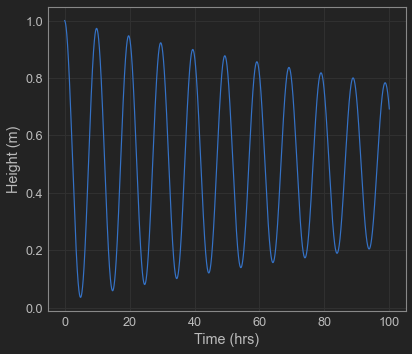

In [14]:
t = np.linspace(0,100,10000)
step_size = t[1]-t[0]
p0 = np.array([1+0*1j,0+0*1j,0+0*1j,0+0*1j])
a = 0
solution = [abs(p0[a])]
for j in range(1,len(t)):
    add = density_der(p0)
    for i in range(4):
        p0[i] += add[i]*step_size 
    solution.append(abs(p0[a]))
plt.plot(t,np.absolute(solution))
plt.xlabel('Time (hrs)')
plt.ylabel('Height (m)')
plt.show()

# Jaynes Cumming Hamiltonian

In [15]:
def jch(N,wc,wa,gamma,Omega,kappa):
    #Operators of the system
    a  = tensor(destroy(N), qeye(2))
    sm = tensor(qeye(N), destroy(2))
    H_field = wc*a*a.dag()
    H_atom = wa*sm.dag()*sm
    H_int = Omega*(a + a.dag())*(sm + sm.dag())
    H = H_field + H_atom + H_int
    
    #Running it
    psi0 = tensor(fock(N,1), fock(2,0))
    t = np.linspace(0,10*np.pi/Omega,10000)
    c_op_list = [np.sqrt(gamma)*sm, np.sqrt(kappa)*a] #Collapse operator
    output = mesolve(H, psi0, t, c_op_list, [a.dag()*a, sm.dag()*sm])
    return output

In [16]:
#Set parameter values
gamma = 3*1e6
Omega = 100*1e6
wc = 100*1e7
delta = 0
wa = wc + delta
N = 16
kappa = np.array([1,10,50,200,300])*1e6
t = np.linspace(0,10*np.pi/Omega,10000)

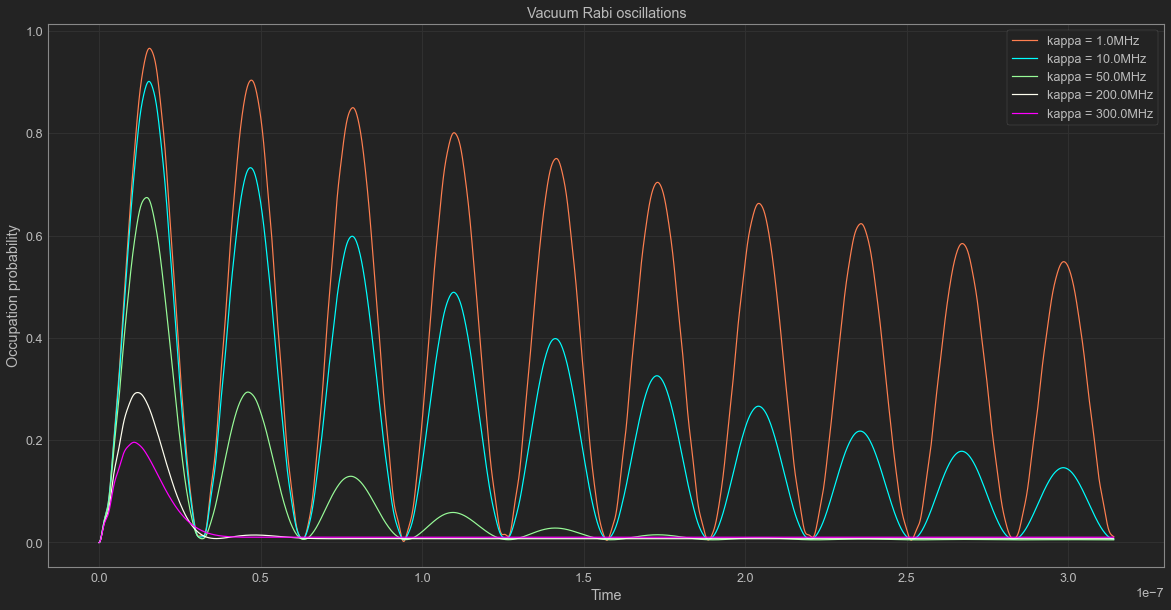

In [17]:
#Graphs\
colors = ['coral','aqua','palegreen','ivory','magenta']
outputs = []
for i in range(len(kappa)):
    output = jch(N,wc,wa,gamma,Omega,kappa[i])
    outputs.append(output)
    plt.plot(t, output.expect[1], c=colors[i], label="kappa = "+str(kappa[i]/1e6)+"MHz")
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.title('Vacuum Rabi oscillations')
plt.gcf().set_size_inches(20,10)
plt.legend()
plt.show()

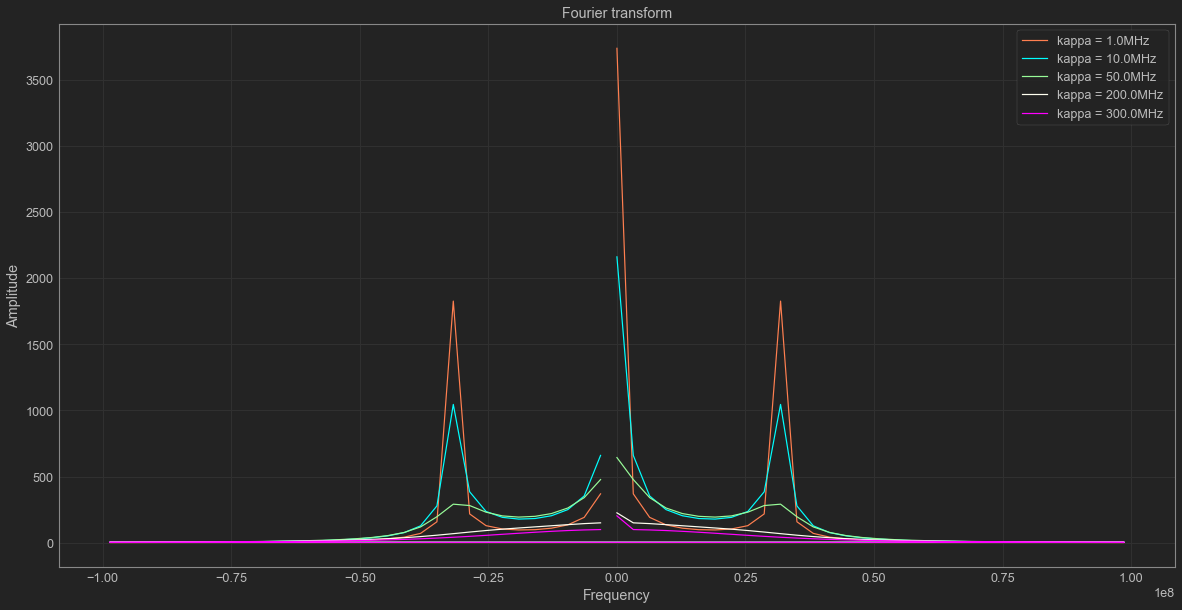

In [18]:
fft_out = []
for i in range(len(outputs)):
    yf = np.absolute(np.fft.fft(outputs[i].expect[1]))
    xf = np.fft.fftfreq(len(t), t[1] - t[0])
    y = []
    x = []
    for j in range(len(xf)):
        if abs(xf[j]) < 1e8:
            x.append(xf[j])
            y.append(yf[j])
    fft_out.append(yf)
    plt.plot(x, y, c=colors[i], label="kappa = "+str(kappa[i]/1e6)+"MHz")
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('Fourier transform')
plt.gcf().set_size_inches(20,10)
plt.legend()
plt.show()

In [19]:
def jch_coh(N,wc,wa,gamma,Omega,kappa,cyc=10,al=1):
    #Operators of the system
    a  = tensor(destroy(N), qeye(2))
    sm = tensor(qeye(N), destroy(2))
    H_field = wc*a*a.dag()
    H_atom = wa*sm.dag()*sm
    H_int = Omega*(a + a.dag())*(sm + sm.dag())
    H = H_field + H_atom + H_int
    
    #Running it
    psi0 = tensor(coherent(N = N,alpha = al), fock(2,0))
    t = np.linspace(0,cyc*np.pi/Omega,1000*cyc)
    c_op_list = [np.sqrt(gamma)*sm, np.sqrt(kappa)*a] #Collapse operator
    output = mesolve(H, psi0, t, c_op_list, [a.dag()*a, sm.dag()*sm])
    return output

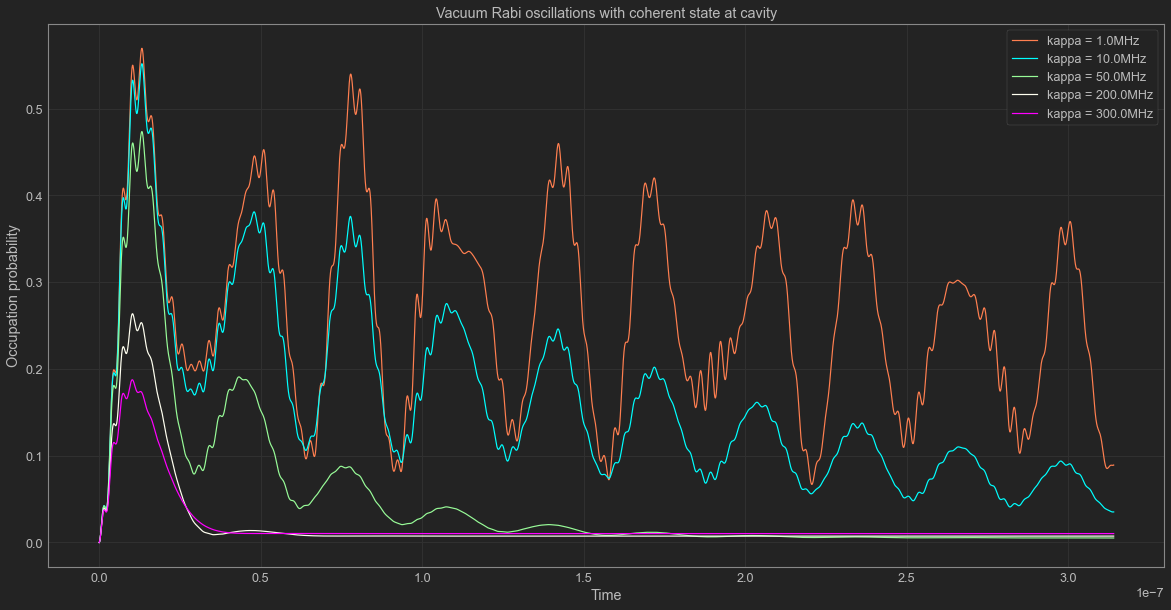

In [20]:
for i in range(len(kappa)):
    output = jch_coh(N,wc,wa,gamma,Omega,kappa[i])
    plt.plot(t, output.expect[1], c=colors[i], label="kappa = "+str(kappa[i]/1e6)+"MHz")
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.title('Vacuum Rabi oscillations with coherent state at cavity')
plt.gcf().set_size_inches(20,10)
plt.legend()
plt.show()

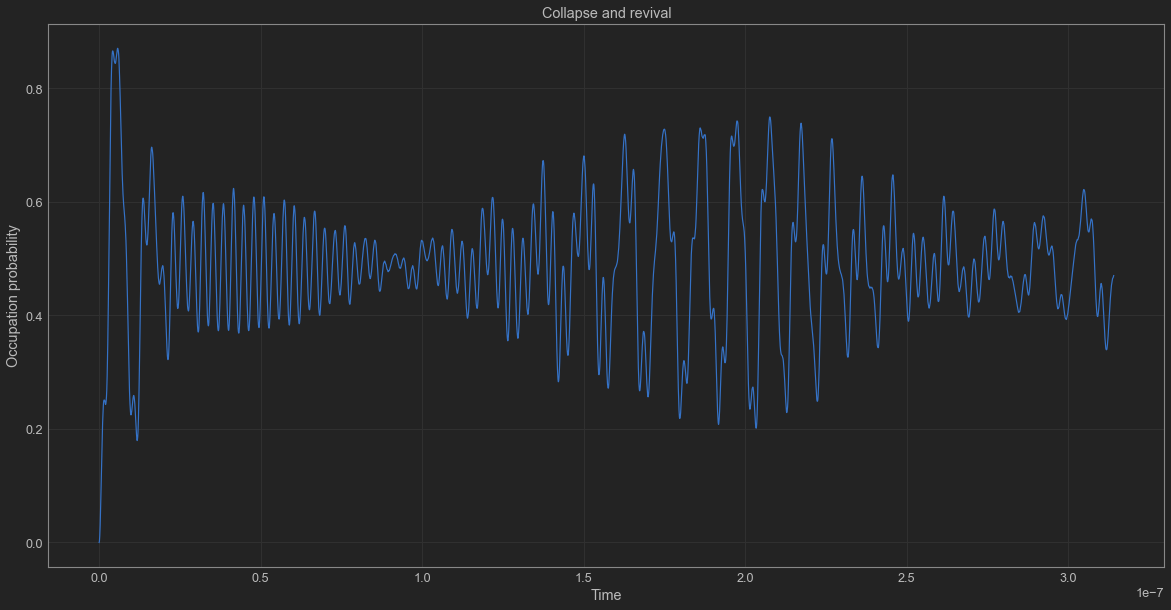

In [21]:
#Collapse and revival
output = jch_coh(N,wc,wa,1e3,Omega,1e3,10,3)
plt.plot(t, output.expect[1])
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.title('Collapse and revival')
plt.gcf().set_size_inches(20,10)
plt.axis()
plt.show()

# STIRAP

In [35]:
def Omega_P1(t, args):
    """Guess for the real part of the pump pulse"""
    Ω0 = 15
    return Ω0 * krotov.shapes.blackman(t, t_start=2.0, t_stop=5.0)


def Omega_P2(t, args):
    """Guess for the imaginary part of the pump pulse"""
    return 0.0


def Omega_S1(t, args):
    """Guess for the real part of the Stokes pulse"""
    Ω0 = 15
    return Ω0 * krotov.shapes.blackman(t, t_start=0.0, t_stop=3.0)


def Omega_S2(t, args):
    """Guess for the imaginary part of the Stokes pulse"""
    return 0.0

In [36]:
def hamiltonian(E1=0.0, E2=10.0, E3=5.0, omega_P=9.5, omega_S=4.5):
    """Lambda-system Hamiltonian in the RWA"""

    # detunings
    ΔP = E1 + omega_P - E2
    ΔS = E3 + omega_S - E2

    H0 = Qobj([[ΔP, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ΔS]])

    HP_re = -0.5 * Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
    HP_im = -0.5 * Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])

    HS_re = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
    HS_im = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])

    return [
        H0,
        [HP_re, Omega_P1],
        [HP_im, Omega_P2],
        [HS_re, Omega_S1],
        [HS_im, Omega_S2],
    ]
H = hamiltonian()

In [37]:
ket1 = qutip.Qobj(np.array([1.0, 0.0, 0.0]))
ket2 = qutip.Qobj(np.array([0.0, 1.0, 0.0]))
ket3 = qutip.Qobj(np.array([0.0, 0.0, 1.0]))
def rwa_target_state(ket3, E2=10.0, omega_S=4.5, T=5):
    return np.exp(1j * (E2 - omega_S) * T) * ket3
psi_target = rwa_target_state(ket3)
objective = krotov.Objective(initial_state=ket1, target=psi_target, H=H)
objective

Objective[|Ψ₈(3)⟩ to |Ψ₉(3)⟩ via [H₁₅[3,3], [H₁₆[3,3], u₁₃(t)], [H₁₇[3,3], u₁₄(t)], [H₁₈[3,3], u₁₅(t)], [H₁₉[3,3], u₁₆(t)]]]

In [38]:
tlist = np.linspace(0, 5, 500)

C:\Users\Mahadevan S\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8346 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Mahadevan S\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8346 missing from current font.
  font.set_text(s, 0, flags=flags)


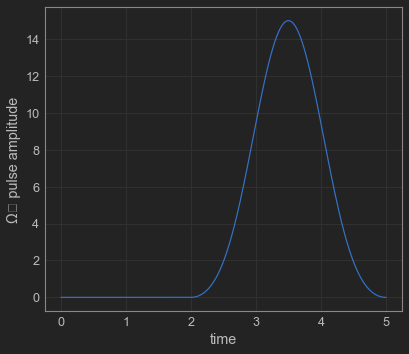

C:\Users\Mahadevan S\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8347 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Mahadevan S\AppData\Roaming\Python\Python37\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8347 missing from current font.
  font.set_text(s, 0, flags=flags)


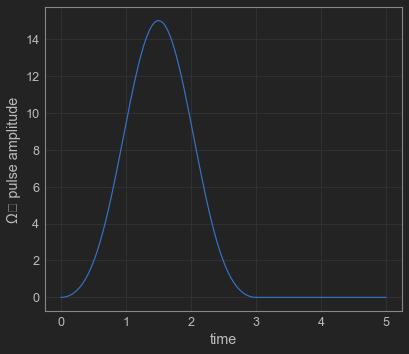

In [39]:
def plot_pulse(pulse, tlist, label):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('%s pulse amplitude' % label)
    plt.show(fig)
plot_pulse(H[1][1], tlist, 'Ωₚ')
plot_pulse(H[3][1], tlist, 'Ωₛ')

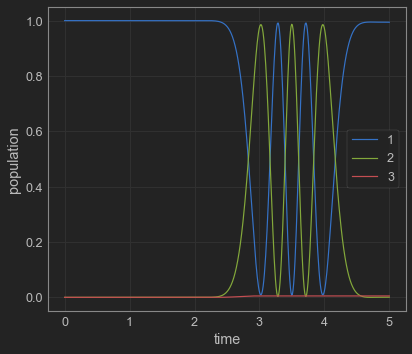

In [40]:
assert np.all([H[2][1](t, None) == 0 for t in tlist])
assert np.all([H[4][1](t, None) == 0 for t in tlist])
proj1 = qutip.ket2dm(ket1)
proj2 = qutip.ket2dm(ket2)
proj3 = qutip.ket2dm(ket3)
guess_dynamics = objective.mesolve(tlist, e_ops=[proj1,proj2,proj3])
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='1')
    ax.plot(result.times, result.expect[1], label='2')
    ax.plot(result.times, result.expect[2], label='3')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)
plot_population(guess_dynamics)

In [41]:
def S(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(
        t, t_start=0.0, t_stop=5.0, t_rise=0.3, func='sinsq'
    )
pulse_options = {
    H[1][1]: dict(lambda_a=0.5, update_shape=S),
    H[2][1]: dict(lambda_a=0.5, update_shape=S),
    H[3][1]: dict(lambda_a=0.5, update_shape=S),
    H[4][1]: dict(lambda_a=0.5, update_shape=S)
}

In [42]:
pulse_options = {
    H[1][1]: dict(lambda_a=0.5, update_shape=S),
    H[2][1]: dict(lambda_a=0.5, update_shape=S),
    H[3][1]: dict(lambda_a=0.5, update_shape=S),
    H[4][1]: dict(lambda_a=0.5, update_shape=S)
}

In [43]:
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options,
    tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.print_table(
        J_T=krotov.functionals.J_T_re,
        show_g_a_int_per_pulse=True,
        unicode=False,
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below(1e-3, name='J_T'),
        krotov.convergence.delta_below(1e-5),
        krotov.convergence.check_monotonic_error,
    ),
    iter_stop=15,
)

iter.      J_T   g_a_int_1   g_a_int_2   g_a_int_3   g_a_int_4    g_a_int          J  Delta J_T    Delta J  secs
0     1.07e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00   0.00e+00   1.07e+00        n/a        n/a    20
1     6.35e-01    2.20e-01    5.20e-03    2.06e-01    4.72e-03   4.37e-01   1.07e+00  -4.37e-01   1.81e-04    40 *
2     3.15e-01    1.74e-01    4.45e-03    1.38e-01    3.02e-03   3.20e-01   6.35e-01  -3.20e-01   1.29e-04    46 *
3     1.40e-01    9.98e-02    2.67e-03    7.14e-02    1.53e-03   1.75e-01   3.16e-01  -1.75e-01   6.76e-05    43 *
4     5.88e-02    4.72e-02    1.28e-03    3.22e-02    6.78e-04   8.13e-02   1.40e-01  -8.13e-02   2.98e-05    38 *
5     2.41e-02    2.03e-02    5.43e-04    1.36e-02    2.85e-04   3.47e-02   5.88e-02  -3.47e-02   1.21e-05    43 *
6     9.75e-03    8.39e-03    2.20e-04    5.59e-03    1.17e-04   1.43e-02   2.41e-02  -1.43e-02   4.80e-06    40 *
7     3.93e-03    3.41e-03    8.73e-05    2.27e-03    4.81e-05   5.81e-03   9.75e-03

In [44]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2021-05-10 19:15:46
- Number of objectives: 1
- Number of iterations: 9
- Reason for termination: Reached convergence: J_T < 0.001
- Ended at 2021-05-10 19:22:26 (0:06:40)

In [45]:
import os
if not os.path.isfile('lambda_rwa_opt_result.dump'):
    opt_result.dump('lambda_rwa_opt_result.dump')

pump pulse amplitude and phase:


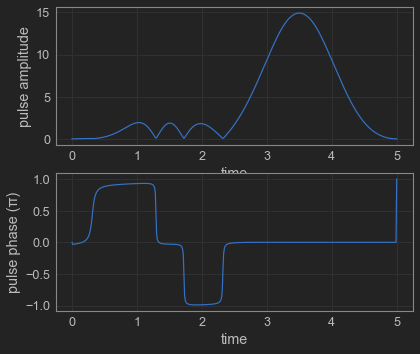

Stokes pulse amplitude and phase:


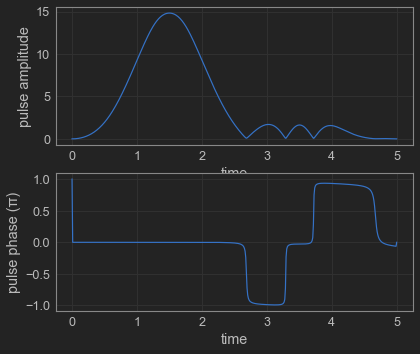

In [46]:
def plot_pulse_amplitude_and_phase(pulse_real, pulse_imaginary,tlist):
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    amplitudes = [np.sqrt(x*x + y*y) for x,y in zip(pulse_real,pulse_imaginary)]
    phases = [np.arctan2(y,x)/np.pi for x,y in zip(pulse_real,pulse_imaginary)]
    ax1.plot(tlist,amplitudes)
    ax1.set_xlabel('time')
    ax1.set_ylabel('pulse amplitude')
    ax2.plot(tlist,phases)
    ax2.set_xlabel('time')
    ax2.set_ylabel('pulse phase (π)')
    plt.show()

print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist)

Physical electric pump pulse in the lab frame:


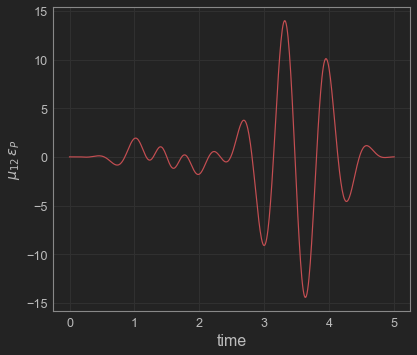

Physical electric Stokes pulse in the lab frame:


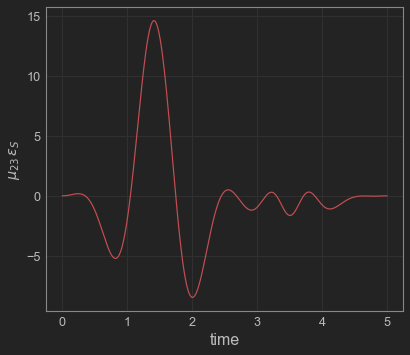

In [47]:
def plot_physical_field(pulse_re, pulse_im, tlist, case=None):

    if case == 'pump':
        w = 9.5
    elif case == 'stokes':
        w = 4.5
    else:
        print('Error: selected case is not a valid option')
        return

    ax = plt.subplot(111)
    ax.plot(tlist,pulse_re*np.cos(w*tlist)-pulse_im*np.sin(w*tlist), 'r')
    ax.set_xlabel('time', fontsize = 16)
    if case == 'pump':
        ax.set_ylabel(r'$\mu_{12}\,\epsilon_{P}$')
    elif case == 'stokes':
        ax.set_ylabel(r'$ \mu_{23}\,\epsilon_{S}$')
    plt.show()

print('Physical electric pump pulse in the lab frame:')
plot_physical_field(
    opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist, case = 'pump')


print('Physical electric Stokes pulse in the lab frame:')
plot_physical_field(
    opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist, case = 'stokes')

In [48]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj1, proj2, proj3])

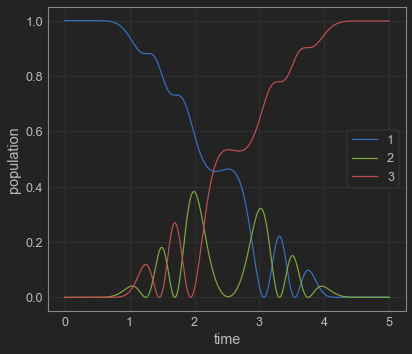

In [49]:
plot_population(opt_dynamics)

# STIRAP using PDEs

In [ ]:
def dc(c,Omega_p,Omega_s):
    